In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tsfresh import extract_features
import config

In [8]:
def ts_fresh_format(input_data, labels, sample_rate=200):
    """
    Converts raw 6-axis sensor data into a long DataFrame suitable for tsfresh.
    Shows progress from 0% to 100%.
    
    input_data: list or array of shape (num_samples, 6, time_steps)
    labels: list of length num_samples
    """
    all_dfs = []
    total = len(input_data)
    time = np.arange(0, len(input_data[0][0, :])) / sample_rate

    for i in range(total):
        sample = input_data[i]
        df = pd.DataFrame({
            'ID': i + 1,
            'Tag': labels[i],
            'Time': time,
            'Acc X': sample[0, :],
            'Acc Y': sample[1, :],
            'Acc Z': sample[2, :],
            'Gyro X': sample[3, :],
            'Gyro Y': sample[4, :],
            'Gyro Z': sample[5, :]
        })
        all_dfs.append(df)

        # Print progress
        if (i + 1) % (total // 100) == 0 or i == total - 1:  # Every 1%
            percent = int((i + 1) / total * 100)
            print(f"\rProgress: {percent}%", end='')

    print("\n✅ Finished creating the DataFrame.")
    df_all = pd.concat(all_dfs, ignore_index=True)
    return df_all

def data_equal_trim(signals):
    min_length = min(matrix.shape[1] for matrix in signals)
    trimmed_signals = []

    for i in range(len(signals)):
        d_length = signals[i].shape[1]
        if d_length > min_length:
            diff = d_length - min_length
            start = diff // 2
            trimmed = signals[i][:, start:start + min_length]
        else:
            trimmed = signals[i].copy()  # keep original if already min length

        trimmed_signals.append(trimmed)
    
    return trimmed_signals

In [9]:
from data_reading_utils import read_sisfall_dataset

base_path = config.sisfall_dataset_path

all_data, all_labels, activity_code_list, adls, falls = read_sisfall_dataset(base_path)

trimmed_data = data_equal_trim(all_data)

trimmed_data = np.array(trimmed_data)

print(f"Number of samples: {len(trimmed_data)}")
print(f"Time steps per sample: {trimmed_data[0].shape[1]}")
print(f"len(all_data): {len(all_data)}")
print(f"all_data[0].shape: {all_data[0].shape}")




Total files processed: 4505
Total ADL labels: 2707
Total Fall labels: 1798
Number of samples: 4505
Time steps per sample: 1999
len(all_data): 4505
all_data[0].shape: (6, 2400)


In [10]:
df_all = ts_fresh_format(trimmed_data, activity_code_list)
df_all
df_all.dtypes

Progress: 100%
✅ Finished creating the DataFrame.


ID          int64
Tag        object
Time      float64
Acc X       int64
Acc Y       int64
Acc Z       int64
Gyro X      int64
Gyro Y      int64
Gyro Z      int64
dtype: object

In [19]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
import pandas as pd

columns_to_use = ['Acc X', 'Acc Y', 'Acc Z', 'Gyro X', 'Gyro Y', 'Gyro Z']

df_signals = df_all[['ID', 'Time'] + columns_to_use]

# ↓ Extract with basic features
extracted_features = extract_features(
    df_signals,
    column_id='ID',
    column_sort='Time',
    default_fc_parameters=MinimalFCParameters(),
    disable_progressbar=False,
    n_jobs=4,
)

# Save extracted features to a CSV file
# extracted_features.to_csv('extracted_features_comprehensive.csv', index=False)


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


In [12]:
# df_tsfresh = pd.melt(
#     df_all,
#     id_vars=['ID', 'Time', 'Tag'],
#     value_vars=['Acc X', 'Acc Y', 'Acc Z', 'Gyro X', 'Gyro Y', 'Gyro Z'],
#     var_name='feature',
#     value_name='value'
# )

# df_tsfresh


In [13]:
downsampled_extracted_features = pd.read_csv('extracted_features_minimal_downsamples.csv')

downsampled_extracted_features

,Acc X__sum_values,Acc X__median,Acc X__mean,Acc X__length,Acc X__standard_deviation,Acc X__variance,Acc X__root_mean_square,Acc X__maximum,Acc X__absolute_maximum,Acc X__minimum,...,Gyro Z__sum_values,Gyro Z__median,Gyro Z__mean,Gyro Z__length,Gyro Z__standard_deviation,Gyro Z__variance,Gyro Z__root_mean_square,Gyro Z__maximum,Gyro Z__absolute_maximum,Gyro Z__minimum
0,-577.0,-10.0,-9.459016,61.0,3.414404,11.658156,10.056398,6.0,17.0,-17.0,...,-491.0,-8.0,-8.049180,61.0,20.199356,4.080140e+02,21.744040,76.0,76.0,-65.0
1,445.0,8.0,7.295082,61.0,5.984527,35.814566,9.435719,27.0,27.0,-8.0,...,-446.0,-6.0,-7.311475,61.0,17.754742,3.152309e+02,19.201264,76.0,76.0,-59.0
2,9504.0,249.0,155.803279,61.0,113.774845,12944.715399,192.923241,287.0,287.0,9.0,...,-988.0,-6.0,-16.196721,61.0,109.535655,1.199806e+04,110.726661,481.0,481.0,-413.0
3,2539.0,58.0,41.622951,61.0,166.927506,27864.792260,172.038549,422.0,422.0,-326.0,...,-1983.0,-395.0,-32.508197,61.0,1331.742795,1.773539e+06,1332.139503,2516.0,2516.0,-2291.0
4,182.0,17.0,2.983607,61.0,119.007300,14162.737436,119.044695,345.0,345.0,-331.0,...,658.0,88.0,10.786885,61.0,948.771131,9.001667e+05,948.832449,1737.0,1993.0,-1993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4500,-10676.0,-235.0,-175.016393,61.0,103.454511,10702.835797,203.306600,61.0,273.0,-273.0,...,-1069.0,0.0,-17.524590,61.0,344.094802,1.184012e+05,344.540773,1059.0,1059.0,-812.0
4501,-9551.0,-200.0,-156.573770,61.0,105.525765,11135.687181,188.814811,-2.0,277.0,-277.0,...,-1820.0,-3.0,-29.836066,61.0,283.561609,8.040719e+04,285.126949,699.0,699.0,-690.0
4502,-335.0,-3.0,-5.491803,61.0,8.838483,78.118785,10.405705,12.0,25.0,-25.0,...,2.0,-5.0,0.032787,61.0,63.229213,3.997933e+03,63.229221,161.0,161.0,-155.0
4503,-886.0,-16.0,-14.524590,61.0,5.932977,35.200215,15.689612,1.0,29.0,-29.0,...,80.0,0.0,1.311475,61.0,38.296317,1.466608e+03,38.318767,129.0,129.0,-104.0


In [14]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(downsampled_extracted_features)

# Ensure all_labels is a pandas Series or numpy ndarray
if not isinstance(all_labels, (pd.Series, np.ndarray)):
    all_labels = pd.Series(all_labels)

features_filtered = select_features(downsampled_extracted_features, all_labels)

features_filtered

,Acc Y__standard_deviation,Acc Y__maximum,Acc Y__variance,Gyro Z__absolute_maximum,Acc Y__mean,Acc Y__median,Acc X__absolute_maximum,Acc Y__sum_values,Gyro Y__absolute_maximum,Acc X__root_mean_square,...,Acc X__sum_values,Acc X__median,Gyro Y__mean,Gyro Y__sum_values,Gyro Y__median,Acc Y__minimum,Gyro X__sum_values,Gyro X__mean,Gyro Z__sum_values,Gyro Z__mean
0,14.386495,-225.0,206.971244,76.0,-246.491803,-254.0,17.0,-15036.0,145.0,10.056398,...,-577.0,-10.0,5.245902,320.0,6.0,-270.0,-3205.0,-52.540984,-491.0,-8.049180
1,25.090591,-98.0,629.537759,76.0,-250.262295,-253.0,27.0,-15266.0,180.0,9.435719,...,445.0,8.0,22.704918,1385.0,18.0,-335.0,-5541.0,-90.836066,-446.0,-7.311475
2,136.483012,77.0,18627.612470,481.0,-64.836066,40.0,287.0,-3955.0,605.0,192.923241,...,9504.0,249.0,30.327869,1850.0,22.0,-263.0,-6434.0,-105.475410,-988.0,-16.196721
3,267.917204,121.0,71779.628057,2516.0,-267.754098,-166.0,422.0,-16333.0,2434.0,172.038549,...,2539.0,58.0,147.721311,9011.0,298.0,-803.0,3853.0,63.163934,-1983.0,-32.508197
4,216.144958,37.0,46718.642838,1993.0,-260.475410,-261.0,345.0,-15889.0,1886.0,119.044695,...,182.0,17.0,-122.098361,-7448.0,-79.0,-588.0,-8617.0,-141.262295,658.0,10.786885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4500,82.266094,20.0,6767.710293,1059.0,-78.622951,-31.0,273.0,-4796.0,932.0,203.306600,...,-10676.0,-235.0,41.245902,2516.0,75.0,-221.0,1123.0,18.409836,-1069.0,-17.524590
4501,88.132569,8.0,7767.349637,699.0,-95.377049,-43.0,277.0,-5818.0,726.0,188.814811,...,-9551.0,-200.0,18.032787,1100.0,70.0,-220.0,66.0,1.081967,-1820.0,-29.836066
4502,40.669974,-97.0,1654.046762,161.0,-178.950820,-177.0,25.0,-10916.0,460.0,10.405705,...,-335.0,-3.0,70.049180,4273.0,67.0,-224.0,1504.0,24.655738,2.0,0.032787
4503,35.559694,-127.0,1264.491803,129.0,-209.000000,-233.0,29.0,-12749.0,257.0,15.689612,...,-886.0,-16.0,70.573770,4305.0,71.0,-241.0,-1636.0,-26.819672,80.0,1.311475


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

         ADL       0.96      0.97      0.97      1079
        Fall       0.96      0.94      0.95       723

    accuracy                           0.96      1802
   macro avg       0.96      0.96      0.96      1802
weighted avg       0.96      0.96      0.96      1802

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

         ADL       0.98      0.99      0.99      1079
        Fall       0.98      0.97      0.98       723

    accuracy                           0.98      1802
   macro avg       0.98      0.98      0.98      1802
weighted avg       0.98      0.98      0.98      1802



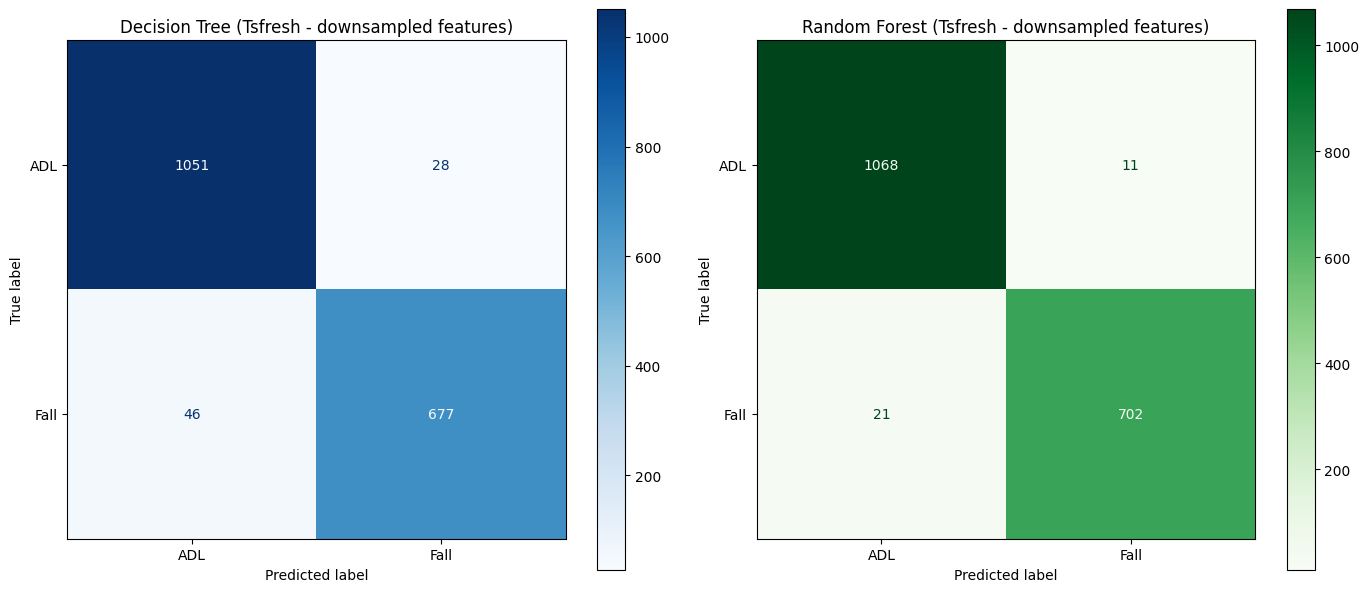

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X = features_filtered 
y = all_labels


# Split your data
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Select features (same for both models)
X_filtered_train = select_features(X_full_train, y_train)
X_filtered_test = X_full_test[X_filtered_train.columns]
X_filtered_train = X_full_train[X_filtered_train.columns]

# ===========================
# Decision Tree Classifier
# ===========================
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_filtered_train, y_train)
y_pred_dt = dt_model.predict(X_filtered_test)

print("=== Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_dt))

# ===========================
# Random Forest Classifier
# ===========================
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_filtered_train, y_train)
y_pred_rf = rf_model.predict(X_filtered_test)

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))

# ===========================
# Plot Confusion Matrices Side by Side
# ===========================
labels = sorted(y.unique())
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=labels)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=labels)
disp_dt.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Decision Tree (Tsfresh - downsampled features)")

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
disp_rf.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title("Random Forest (Tsfresh - downsampled features)")

plt.tight_layout()
plt.show()
